# **Finding Lane Lines on the Road** 
### Utilizing computer vision techniques and smoothing to detect lanes in varying conditions.

![title](Pipeline_visualized.png)

## The pipeline 

1. Smoothing using gaussian blur 
2. Canny Edge detection 
3. Masking region of interest 
4. Hough Transform to identify lines
5. From Hough lines, calculate gradient of all lines 
6. Threshold lines to remove vertical lines 
7. Filter lines by positive and negative gradients to get left and right lines 
8. Calculate average gradient and b of longest n lines 
9. Get equation of line, find endpoints and plot on the image 
10. To increase stablitiy of lines under changing conditions, introduce smoothing , by averaging the last 10 frames


**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


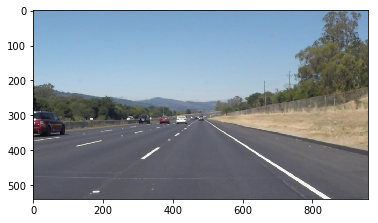

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img,lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [17]:
def find_lanes(image, display=False, blur_kernel=5,canny_high=200, canny_low=70, h_theta=1, h_rho=2,
                 h_thres=20, h_max_line_gap=2,h_min_line_len=2):
    
    # Get Image resolution=shape
    res = image.shape
    
    # Grayscale 
    #gray = grayscale(image)
    
    # Smoothing image with gaussian blur
    blur = gaussian_blur(image, kernel_size=blur_kernel)
    
    fintune_lanes.append(blur)
    if display:
        print ("Gaussian Blur")
        plt.imshow(blur)
        plt.show()

    # Canny edge detection
    edges = canny(blur, canny_low, canny_high)
    
    fintune_lanes.append(edges)
    if display:
        print ("Canny Edge Detection")
        plt.imshow(edges)
        plt.show()

    # Selecting Area of intrest with mask, rmbr top left of img is (0,0)
    vertices_mask = np.array([[(110,res[0]),(res[1]/2-25, res[0]/2+50),
                          (res[1]/2+25, res[0]/2+50), (res[1]-20,res[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices=vertices_mask)
    
    fintune_lanes.append(masked_edges)
    if display:
        print ("Masked Edges")
        plt.imshow(masked_edges)
        plt.show()

    # Hough transform to get line segments
    rho = h_rho # distance resolution in pixels of the Hough grid
    theta = h_theta * np.pi/180 # angular resolution in radians of the Hough grid
    threshold = h_thres     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = h_min_line_len # minimum number of pixels making up a line
    max_line_gap = h_max_line_gap   # maximum gap in pixels between connectable line segments
    
    line_img, lines = hough_lines(masked_edges,rho, theta, threshold, min_line_len, max_line_gap)
    
    fintune_lanes.append(line_img)
    if display:
        print ("Hough Lines")
        plt.imshow(line_img)
        plt.show()

    # Draw mask on image mask
    # line_img = draw_vertices(line_img, vertices)
    
    # Superimpose lines onto image
    result_img = weighted_img(line_img, image, α=0.8)
    
    fintune_lanes.append(result_img)
    if display:
        print ("Result")
        plt.imshow(result_img)
        plt.show()

    return result_img, lines

def detect_connected_lanes(image, **kwargs):
    # Get Image resolution=shape
    imshape = image.shape
    
    # To get hough lines 
    result, lines = find_lanes(image, **kwargs)
    
    # Calculate gradient of lines (y1-y2)/(x1-x2)
    lines = np.squeeze(lines)
    
    # Slice to get x1 y1...returns array of gradients
    grad = (lines[:,3]-lines[:,1]) / (lines[:,2] - lines[:,0])
    
    # Length of lines
    line_size = np.sqrt((lines[:,2] - lines[:,0])**2 + (lines[:,3]-lines[:,1])**2)
    
    # Thresholding to remove vertical lines
    max_grad = 0.5
    lines = lines[np.abs(grad)>max_grad]
    line_size = line_size[np.abs(grad)>max_grad]
    grad = grad[np.abs(grad)>max_grad]
    
    # Seprate left and right lines by positive and negative gradients
    grad_p, grad_n = grad[grad>0], grad[grad<0]
    lines_p, lines_n = lines[grad>0,:], lines[grad<0,:]
    line_size_p, line_size_n = line_size[grad>0], line_size[grad<0]
    
    # argsort returns the indices that would sort an array
    p_line_sorted_bysize = np.argsort(line_size_p) 
    n_line_sorted_bysize = np.argsort(line_size_n)
    
    # Calculate average grad on the biggest n lines. n =  number of the longest_lines
    # Slice the last 5 longest lines and find the mean
    longest_lines = -5
    
    # p_line_sorted_bysize sorts the grads by size and then longest_lines take the last 5 of the longest lines and computes mean grad
    grad_pos_avg, grad_neg_avg = grad_p[p_line_sorted_bysize][longest_lines::].mean(), grad_n[n_line_sorted_bysize][longest_lines::].mean()
    
    # Calculate b = y - m * x, by getting slicing all x and y values from lines
    x_vals_p, y_vals_p = np.concatenate([lines_p[:,0],lines_p[:,2]]), np.concatenate([lines_p[:,1],lines_p[:,3]])
    x_vals_n, y_vals_n = np.concatenate([lines_n[:,0],lines_n[:,2]]), np.concatenate([lines_n[:,1],lines_n[:,3]])
    b_p, b_n = y_vals_p - (grad_pos_avg * x_vals_p), y_vals_n - (grad_neg_avg * x_vals_n)
    
    # Calculate average b again based on n biggest lines
    b_p = b_p[p_line_sorted_bysize][longest_lines::]
    b_n = b_n[n_line_sorted_bysize][longest_lines::]
    b_p_avg, b_n_avg = np.mean(b_p), np.mean(b_n) 
    
    # Get y and x for left and right lane
    y1_pn = imshape[0]
    x1_p = (y1_pn - b_p_avg) / grad_pos_avg
    x1_n = (y1_pn - b_n_avg) / grad_neg_avg
    
    # For challenge video
    y2_pn = imshape[0]/1.55
    
#     Dynamic lane endings uncomment next line. 
#     y2_pn = np.min(np.concatenate([y_vals_n[n_line_sorted_bysize][longest_lines::],y_vals_p[p_line_sorted_bysize][longest_lines::]]))
    
    x2_p = (y2_pn - b_p_avg) / grad_pos_avg
    x2_n = (y2_pn - b_n_avg) / grad_neg_avg 
    
    # Put points together as lane
    lanes = np.array([[[x1_p,y1_pn,x2_p,y2_pn],[x1_n,y1_pn,x2_n,y2_pn]]],dtype=np.int32)
  
    return lanes
 
def decrease_brightness(img,brightness=50):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv

    h, s, v = cv2.split(hsv)
    v -= brightness
    final_hsv = cv2.merge((h, s, v))

    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

# Gamma correction function
def adjust_gamma(image, gamma=1.0):
    # Build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def average_lines(saved_lines, smoothing_factor=5):
    #save 'count' number of lines and returns the average of the 'count' lines
    saved_lines = np.squeeze(saved_lines)
    l_line = [0,0,0,0]
    r_line = [0,0,0,0]
    for count,line in enumerate(reversed(saved_lines)):   
        if count == smoothing_factor:
            break
        l_line += line[0]
        r_line += line[1]
    l_line = l_line / smoothing_factor
    r_line = r_line / smoothing_factor
    return np.array([[l_line,r_line]], dtype=np.int32)

def plot_images(images, cols=5, figsize=(8, 4)):
    n_img = len(images)
    rows = math.ceil(n_img/cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    subplots = axes.ravel()

    for n, subplot in enumerate(subplots):
        if (n < n_img):
            image = images[n]
            if len(image.shape) < 3:
                subplots[n].imshow(image, cmap='gray')
            else:
                subplots[n].imshow(image)
            subplots[n].axis('off')
        else:
            subplots[n].axis('off')
    plt.show()
    
    
def draw_lines_on_image(image, lines_connected):
    # Add lanes to image
    line_img = np.zeros_like(image)
    draw_lines(line_img, lines_connected, color=[200,0,200], thickness=12)
    maskfill = np.array([])
    # Overlay image and lanes
    result = weighted_img(line_img, image, α=0.8)   
    return result

## Parameters to finetune 

* dst: Output of the edge detector. It should be a grayscale image (although in fact it is a binary one)
* lines: A vector that will store the parameters (x_{start}, y_{start}, x_{end}, y_{end}) of the detected lines
* rho : The resolution of the parameter r in pixels. We use 1 pixel.
* theta: The resolution of the parameter \theta in radians. We use 1 degree (CV_PI/180)
* threshold: The minimum number of intersections to “detect” a line
* minLinLength: The minimum number of points that can form a line. Lines with less than this number of points are * disregarded.
* maxLineGap: The maximum gap between two points to be considered in the same line.

Canny Thresholding 
* If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
* If a pixel gradient value is below the lower threshold, then it is rejected.
* If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel * that is above the upper threshold.


Parameter Set 1


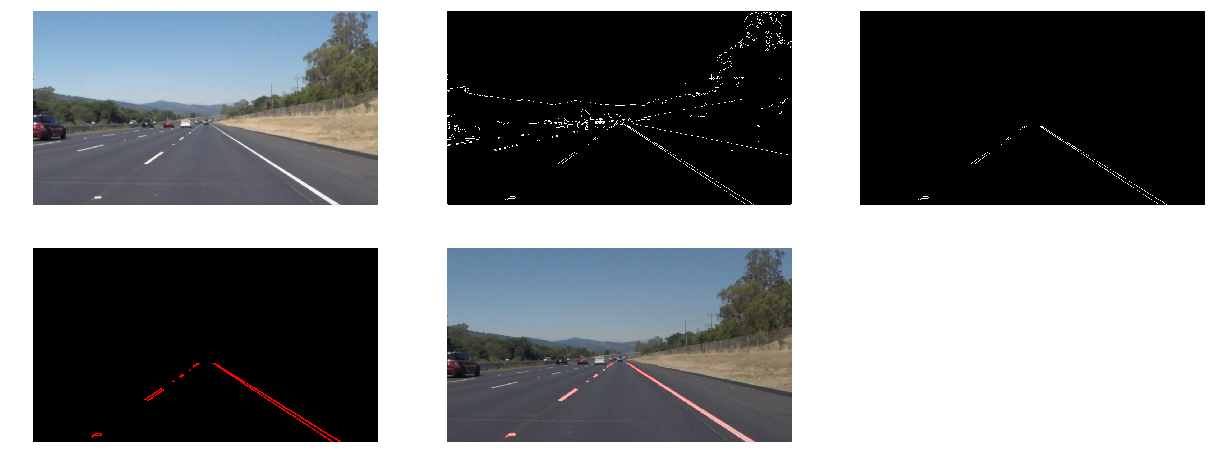

Parameter Set 2


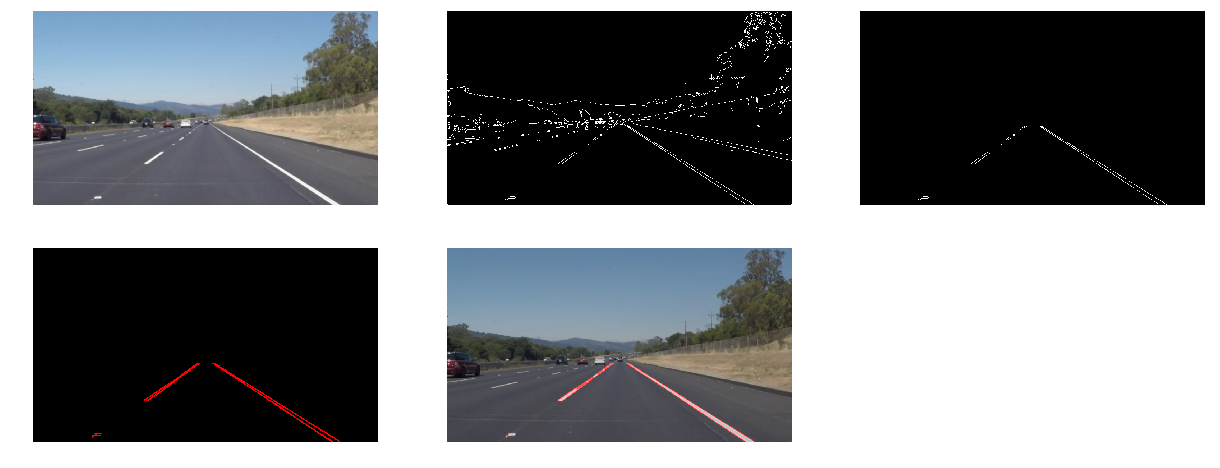

Parameter Set 3


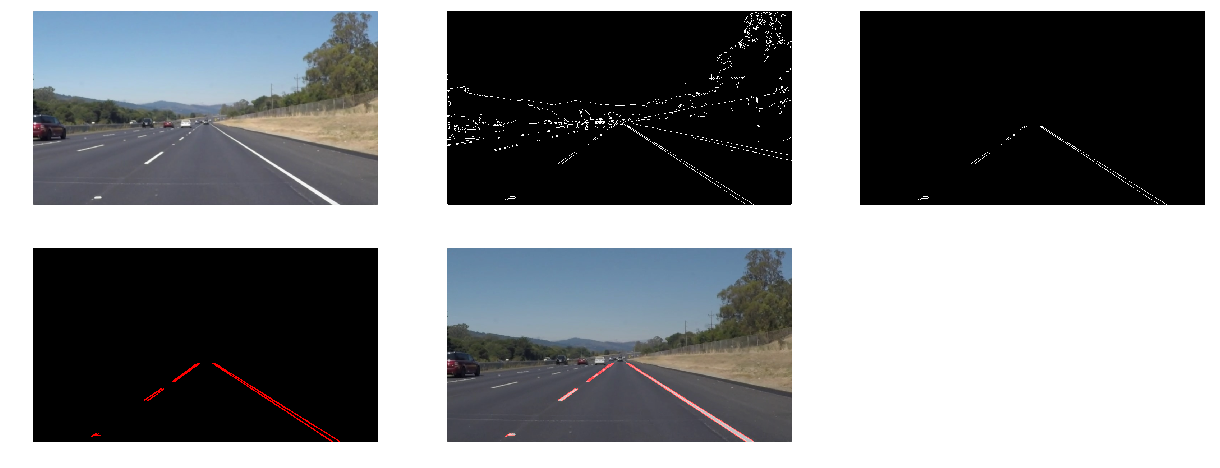

In [5]:
fintune_lanes=[]
image = mpimg.imread('test_images/solidWhiteRight.jpg')
result = find_lanes(image, display=False, blur_kernel=3,canny_high=190, canny_low=70, h_theta=1, h_rho=2,
                 h_thres=15, h_max_line_gap=4,h_min_line_len=3)

print ("Parameter Set 1")
plot_images(fintune_lanes, cols=3, figsize=(21, 8))

fintune_lanes=[]
result = find_lanes(image, display=False, blur_kernel=3,canny_high=155, canny_low=50, h_theta=1, h_rho=2,
                 h_thres=15, h_max_line_gap=30,h_min_line_len=5)

print ("Parameter Set 2")
plot_images(fintune_lanes, cols=3, figsize=(21, 8))

fintune_lanes=[]
result = find_lanes(image, display=False, blur_kernel=3,canny_high=155, canny_low=55, h_theta=1, h_rho=2,
                 h_thres=20, h_max_line_gap=20,h_min_line_len=8)

# result = find_lanes(image, display=False, blur_kernel=5,canny_high=200, canny_low=70, h_theta=1, h_rho=2,
#                  h_thres=20, h_max_line_gap=2,h_min_line_len=2)
print ("Parameter Set 3")
plot_images(fintune_lanes, cols=3, figsize=(21, 8))

### Testing Gamma Correction for Roads with different contrast

Testing to see if applying gamma correction following by brightness reduction will help in cases where changing road contrast occurs

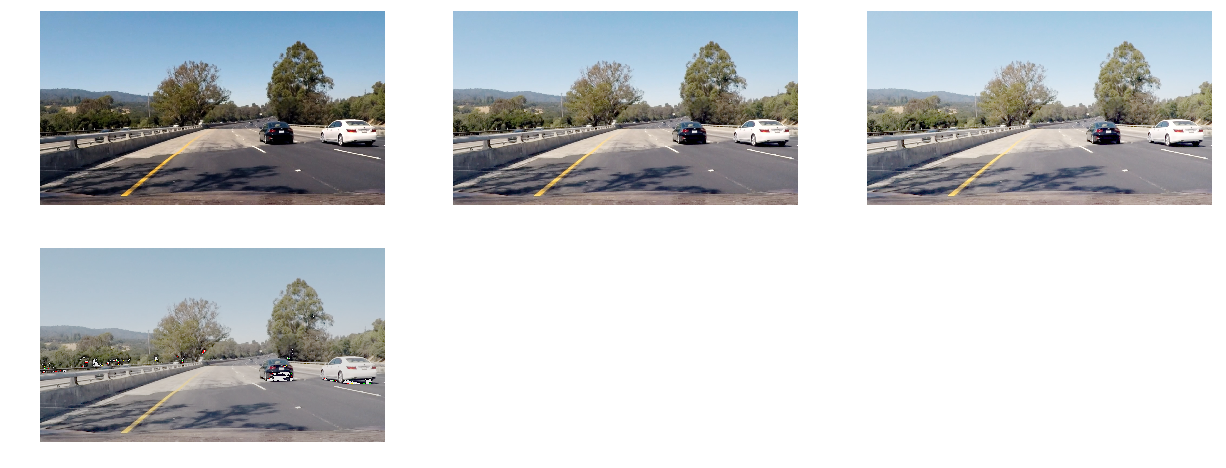

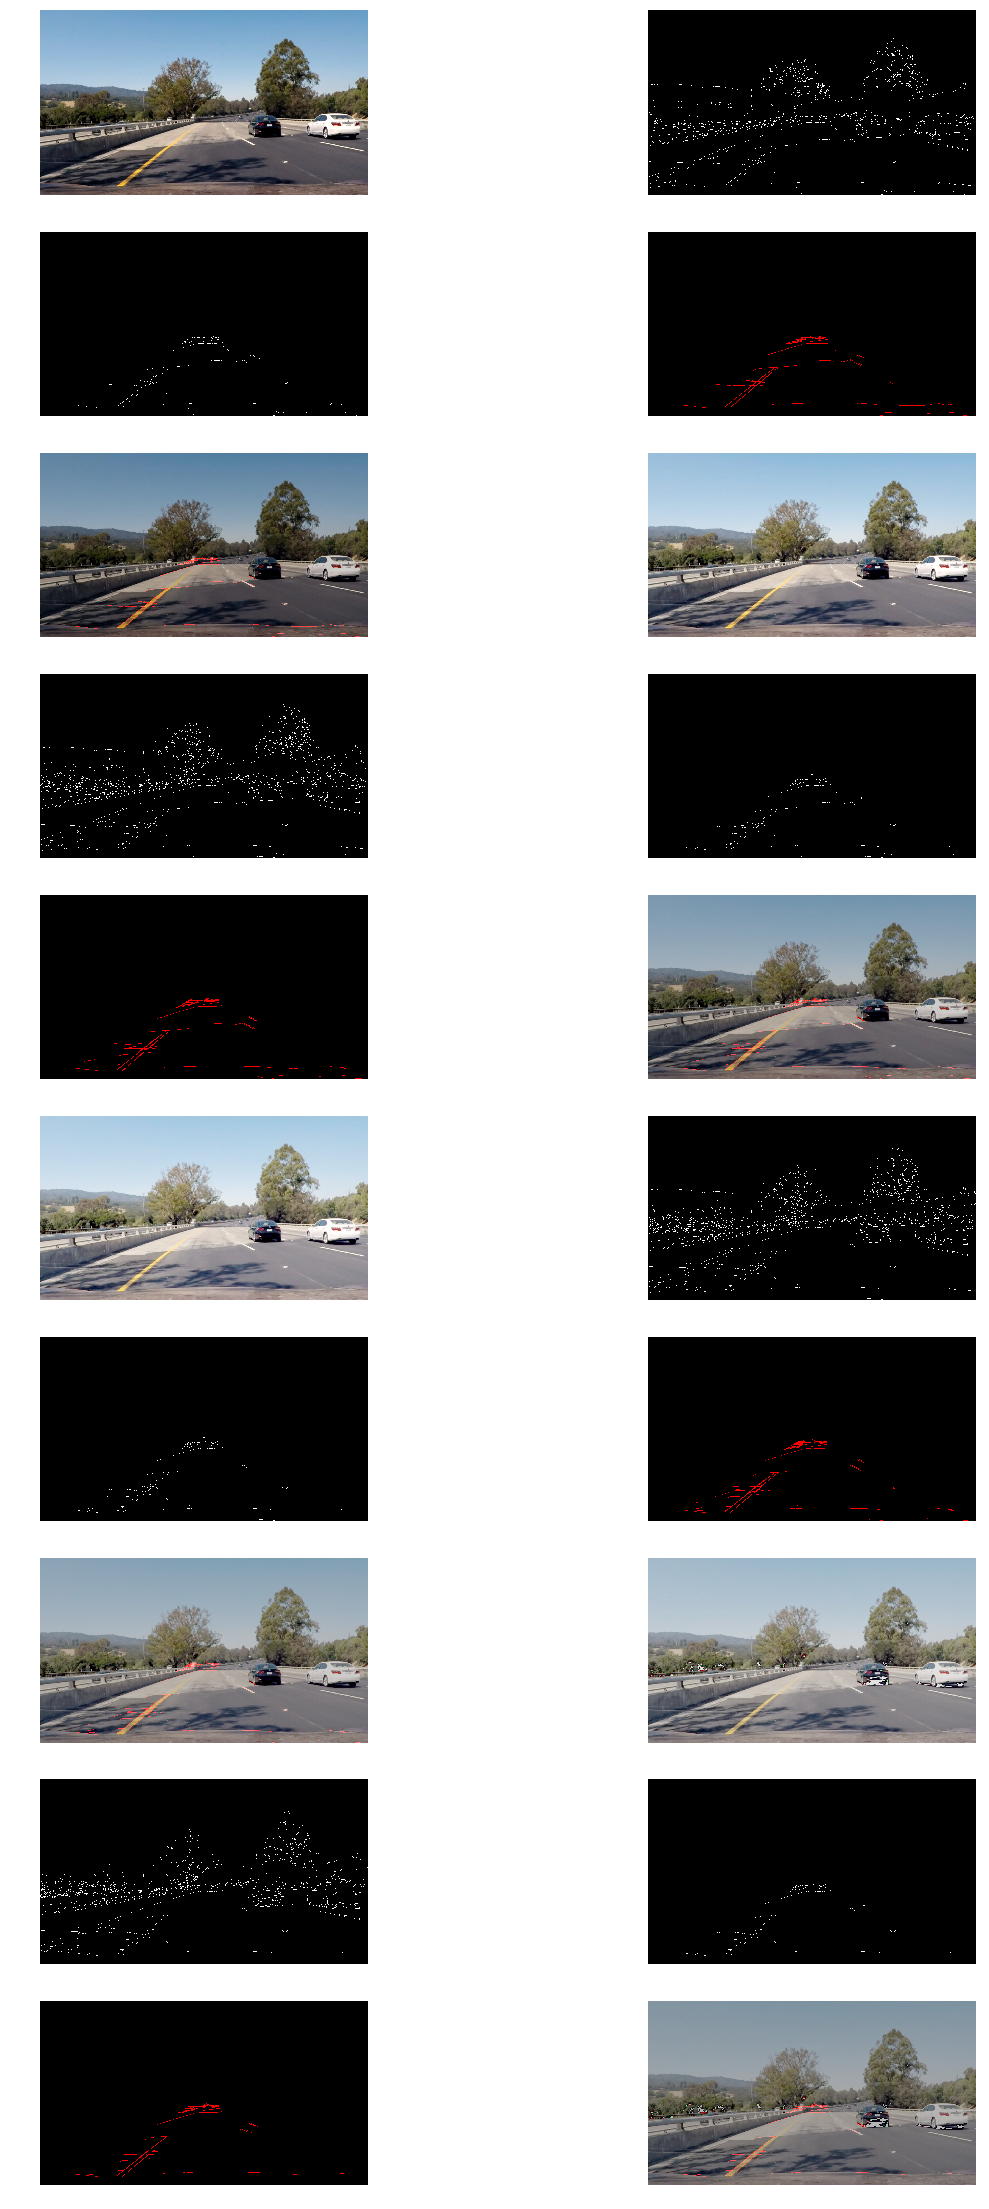

In [6]:
image = mpimg.imread('test_images/challenge.jpg')
#Gamma settings
gamma_setting = []
result = adjust_gamma(image,gamma=1.0)
gamma_setting.append(result)

result = adjust_gamma(image,gamma=1.5)
gamma_setting.append(result)


result = adjust_gamma(image,gamma=2.0)
gamma_setting.append(result)

result = adjust_gamma(image,gamma=2.5)
result = decrease_brightness(result,brightness=30)
gamma_setting.append(result)
plot_images(gamma_setting, cols=3, figsize=(21, 8))

fintune_lanes=[]
for img in gamma_setting:
    result = find_lanes(img, display=False, blur_kernel=3,canny_high=155, canny_low=55, 
                        h_theta=1, h_rho=2,h_thres=55, h_max_line_gap=25,h_min_line_len=10)
    
plot_images(fintune_lanes, cols=2, figsize=(20, 40))

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

### Unconnected Lines Pipeline

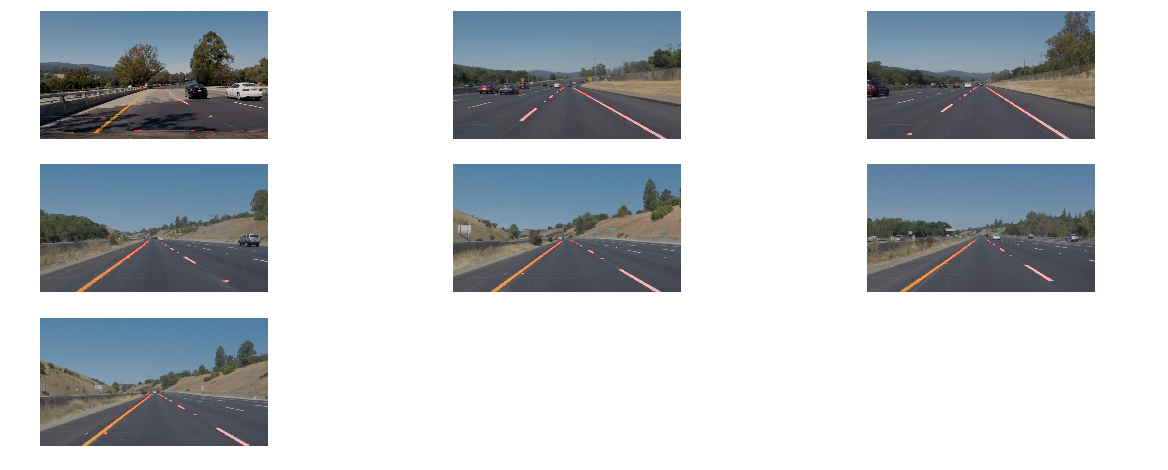

In [7]:
import glob
paths = glob.glob('test_images/*.jpg')
testlanes=[]
for i,image_path in enumerate(paths):
    image = mpimg.imread(image_path)
    result, lines = find_lanes(image)
    testlanes.append(result)
    mpimg.imsave('test_images/detected/'+image_path[12:-4]+'_detected.jpg', result)
    
plot_images(testlanes, cols=3, figsize=(21, 8))

### Connected Lines Pipeline

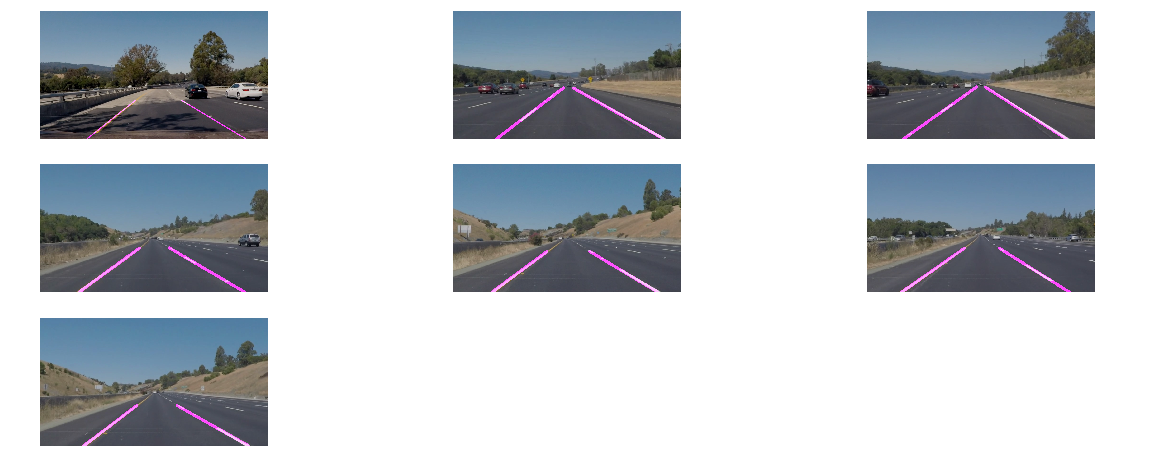

In [8]:
con_testlanes=[]
for i,image_path in enumerate(paths):
    image = mpimg.imread(image_path)
    lines_connected = detect_connected_lanes(image)
    result = draw_lines_on_image(image, lines_connected)
    con_testlanes.append(result)
    mpimg.imsave('test_images/detected/'+image_path[12:-4]+'_detected.jpg', result)
    
plot_images(con_testlanes, cols=3, figsize=(21, 8))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
# Smoothing factor decides how stable the lanes by varying the length of saved_lines
saved_lines = []
smoothing_factor = 7

def process_image(image):
    # Detect lines     
    lines_connected = detect_connected_lanes(image, display=False, blur_kernel=3,canny_high=160, canny_low=85, 
                                             h_theta=1, h_rho=2,h_thres=55, h_max_line_gap=30,h_min_line_len=3)

    
    # add line to memory for stabilization
    saved_lines.append(lines_connected)
    
    #  after n frames start stabilizing
    if len(saved_lines) > smoothing_factor:
        lines_connected = average_lines(saved_lines, smoothing_factor)
    result = draw_lines_on_image(image, lines_connected)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
saved_lines = [] #Reset smoothing variable
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 55.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.92 s, sys: 1.34 s, total: 6.26 s
Wall time: 4.41 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
saved_lines = [] #Reset smoothing variable
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:14<00:00, 46.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 16.8 s, sys: 4.92 s, total: 21.7 s
Wall time: 15 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [21]:
saved_lines = [] #Reset smoothing variable
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:14<00:00, 15.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 13 s, sys: 3.88 s, total: 16.9 s
Wall time: 16 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))